#Single-photon Classification

##Training

In [0]:
# We need this version, since 2.1.x and 2.2.x have a complex-gradient bug.
!pip3 install tensorflow-gpu==2.0.1

In [0]:
from google.colab import files
import numpy
import tensorflow.compat.v2 as tf
import tensorflow.compat.v2.keras as keras
from matplotlib import pyplot

numpy.set_printoptions(linewidth=200)
rng = numpy.random.RandomState(seed=2)

# The computationally expensive part is exponentiating the Lie algebra element
# to obtain the SU(790) "de-mixing" basis transformation.
# This is then applied to all items in the batch uniformly. Since the rest
# of the computation is easy, this suggests we should go with large batch sizes.

BATCH_SIZE = 8192
NUM_CLASSES = 10
XDIM = 28
XYDIM = 784
XYDIM_EXT = 790

# Choose one of the following sets.

DATASET = tf.keras.datasets.mnist
# DATASET = tf.keras.datasets.fashion_mnist


In [20]:
# Uploading a model trained earlier (if available). In this way, one can train
# further an existing model.
# e.g.:
# for fashion_mnist use fashion_mnist_trained_U790.npy
# for mnist use mnist_trained_U790.npy

uploaded_h0 = None

print('Upload a pre-trained model *.npy file if available.\n'
      'Otherwise, a new model will be trained.\n\n')
uploaded_files = None
while True:
  uploaded_files = files.upload()
  if not uploaded_files:  # User does not upload a model file.
    print('No user-provided model. Training a new model.')
    break
  if (len(uploaded_files) > 2 or
      not all(x.endswith('.npy') for x in uploaded_files.keys())):
    print('Please only upload exactly one .npy file')
    continue
  try:
    uploaded_h0 = numpy.load(list(uploaded_files)[0]).astype(numpy.float64)
    if uploaded_h0.shape != (XYDIM_EXT, XYDIM_EXT):
      print('Matrix size mismatch.')
      continue
    break
  except Exception as e:
    print('Parse error:', e)


Upload a pre-trained model *.npy file if available.
Otherwise, a new model will be trained.




Saving fashion_mnist_trained_U790.npy to fashion_mnist_trained_U790.npy


In [21]:
# Trained the current model (or a new one, if none was uploaded.)
# Results are periodically saved in the file h0.npy on the colab server.
# Training can be stopped any time with the cell "stop" button and the most
# recent model file can be downloaded locally with the download_model()
# function ran in the next cell. 

(x_train255, y_train), (x_test255, y_test) = DATASET.load_data()
x_train, x_test = (x_train255 / 255.0), (x_test255 / 255.0)
# Quantum amplitudes of the incoming photon as it passed the filter.
# We must normalize to total_intensity=1, since we see 1 photon.
# Also, we pad to

def quantum_states_from_xs(xs):
  amplitudes = numpy.sqrt(
      xs / numpy.einsum('byx->b', xs)[:, numpy.newaxis, numpy.newaxis])
  return numpy.pad(amplitudes.reshape(xs.shape[0], -1),
                  ((0, 0), (0, XYDIM_EXT - XYDIM)))
  
xq_train = quantum_states_from_xs(x_train)
xq_test = quantum_states_from_xs(x_test)

y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)

train_ds = tf.data.Dataset.from_tensor_slices(
    (xq_train, y_train_cat)).shuffle(10000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (xq_test, y_test_cat)).batch(BATCH_SIZE)

# "Classical baseline" performance:
# If a pixel arrives at (row, col), we need to know the most likely digit,
# with probabilities as observed on the training set.
x_train_intensity_per_cat = (
    numpy.einsum('byx,bc->yxc', x_train, y_train_cat) +
    # Trick: We add a tiny randomized-for-random-tie-breaking 'epsilon'
    # to the brightnesses that only changes results for pixels that were
    # dark in every single training example.
    rng.uniform(low=0, high=1e-100, size=(28, 28, 10)))
x_train_most_likely_pixel_cat = keras.utils.to_categorical(
    x_train_intensity_per_cat.argmax(axis=2))

# For every test-set image, we need to find out what fraction of photons
# would make our classifier predict the category correctly.
x_test_batched_total_photons_yielding_correct_cat = numpy.einsum(
    'byx,yxc,bc->b', x_test, x_train_most_likely_pixel_cat, y_test_cat)
x_test_fraction_photons_yielding_correct_cat = (
    x_test_batched_total_photons_yielding_correct_cat / numpy.einsum('byx->b', x_test))
baseline_accuracy = numpy.round(x_test_fraction_photons_yielding_correct_cat.mean(), 4)
# Baseline accuracy 21.27% is found to be RNG seed independent.
# (Seed influences assignment of dark-everywhere-on-training-set pixels.
# So, apparently, the test-set does not have relevant ink on pixels that are
# dark on the training set.)
print('Classical-detection baseline accuracy: %.2f%%' %
      (100 * baseline_accuracy))

k_h0 = tf.keras.backend.variable(
     (uploaded_h0 if uploaded_h0 is not None
      else rng.normal(size=(XYDIM_EXT, XYDIM_EXT), scale=0.01)),
     dtype='float64', name='H0')

x_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)


@tf.function
def get_loss_accuracies_u(h0, psi, labels):
  h0_T = tf.transpose(h0)
  DDD_ORTHO_ONLY = 1.0  # DDD Use 1.0 for unitary.
  ih = tf.complex(h0 - h0_T, DDD_ORTHO_ONLY * (h0 + h0_T))
  u = tf.linalg.expm(ih)
  u_psi = tf.reshape(
      tf.einsum('bp,qp->bq', tf.cast(psi, tf.complex128), u),
      (-1, NUM_CLASSES, XYDIM_EXT // NUM_CLASSES))
  u_psi_r = tf.math.real(u_psi)
  u_psi_i = tf.math.imag(u_psi)
  probs = tf.einsum('bcs->bc', tf.math.square(u_psi_r) + tf.math.square(u_psi_i))
  loss = x_loss(tf.cast(labels, tf.float64), probs)
  batch_quantum_accuracy = (
      tf.einsum('bc,bc->', tf.cast(labels, tf.float64), probs) /
      tf.reduce_sum(tf.ones_like(labels[:, 0], dtype=tf.float64))) # XXX Fix code wart.
  batch_manyphoton_accuracy = tf.math.reduce_mean(
      keras.metrics.categorical_accuracy(labels, probs))
  return loss, batch_quantum_accuracy, batch_manyphoton_accuracy, u


def train_step(optimizer, k_h0, psis, labels):
  c1 = tf.constant(1.0, dtype=tf.float64)
  tape = tf.GradientTape()
  with tape:
    tape.watch(k_h0)
    loss, accuracy_q, accuracy_m, u = get_loss_accuracies_u(k_h0, psis, labels)
  gradients = tape.gradient(loss, [k_h0])
  optimizer.apply_gradients(zip(gradients, [k_h0]))
  return loss, accuracy_q, accuracy_m, u

def get_test_set_accuracies(h0):
  loss, accuracy_q, accuracy_m, u = get_loss_accuracies_u(
      h0, xq_test, y_test_cat)
  del loss, u  # Unused.
  return accuracy_q, accuracy_m


def download_model():
  """Downloads a model from colab."""
  accuracy_q, accuracy_m = get_test_set_accuracies(k_h0.numpy())
  print("This model's test set accuracy: Quantum=%.2f%%, Manyphoton=%.2f%%" %
        (100 * accuracy_q, 100 * accuracy_m))
  files.download('h0.npy') 


def train_a_model(stage1_steps=2, stage2_steps=2):
  """Trains a model.
  
  Interrupting this function will produce a valid partially-trained model.
  """
  optimizer1 = tf.keras.optimizers.SGD(learning_rate=0.3)
  optimizer2 = tf.keras.optimizers.SGD(learning_rate=0.03)
  for ep in range(stage1_steps):
    for n, (xq_img, labels) in enumerate(train_ds):
      loss, accuracy_q, accuracy_m, u = train_step(
          optimizer1, k_h0, xq_img, labels)
      tr_u = tf.linalg.trace(u)
      if n % 5 == 0:
        print('DDD-E=%d STEP=%04d, loss=%.3f, acc_q=%.3f, acc_m=%.3f, tr_U=%s' %
              (ep, n, loss.numpy(), accuracy_q.numpy(), accuracy_m.numpy(),
               numpy.round(tr_u.numpy(), 3)))
      if n == 0 and ep % 10 == 0:
        print('Test Set accuracies: %.4f / %.4f' %
              get_test_set_accuracies(k_h0))
  for ep in range(stage2_steps):
    for n, (xq_img, labels) in enumerate(train_ds):
      loss, accuracy_q, accuracy_m, u = train_step(
          optimizer2, k_h0, xq_img, labels)
      tr_u = tf.linalg.trace(u)
      if n % 5 == 0:
        print('DDD-E=%d STEP=%04d, loss=%.3f, acc_q=%.3f, acc_m=%.3f, tr_U=%s' %
              (ep, n, loss.numpy(), accuracy_q.numpy(), accuracy_m.numpy(),
               numpy.round(tr_u.numpy(), 3)))
      if n == 0 and ep % 10 == 0:
        print('Test Set accuracies: %.4f / %.4f' % get_test_set_accuracies(k_h0))
        numpy.save('h0.npy', k_h0.numpy())
        print('Saved model')

train_a_model()

print('Model accuracies: %.4f / %.4f' % get_test_set_accuracies(k_h0))


Classical-detection baseline accuracy: 21.27%
DDD-E=0 STEP=0000, loss=2.545, acc_q=0.098, acc_m=0.108, tr_U=(555.096+0.292j)
Test Set accuracies: 0.1243 / 0.1220
DDD-E=0 STEP=0005, loss=1.692, acc_q=0.198, acc_m=0.540, tr_U=(554.42+0.271j)
DDD-E=1 STEP=0000, loss=1.528, acc_q=0.233, acc_m=0.692, tr_U=(553.849+0.26j)
DDD-E=1 STEP=0005, loss=1.396, acc_q=0.268, acc_m=0.767, tr_U=(552.992+0.24j)
DDD-E=0 STEP=0000, loss=1.342, acc_q=0.284, acc_m=0.788, tr_U=(552.515+0.229j)
Test Set accuracies: 0.2861 / 0.8065
Saved model
DDD-E=0 STEP=0005, loss=1.343, acc_q=0.285, acc_m=0.791, tr_U=(552.445+0.227j)
DDD-E=1 STEP=0000, loss=1.338, acc_q=0.285, acc_m=0.793, tr_U=(552.402+0.225j)
DDD-E=1 STEP=0005, loss=1.331, acc_q=0.288, acc_m=0.792, tr_U=(552.334+0.223j)
Model accuracies: 0.2917 / 0.8131


In [23]:
# Download model file locally.

download_model()

This model's test set accuracy: Quantum=29.17%, Manyphoton=81.31%


In [0]:
# Studying projectors.

cat_projectors = [
    numpy.diag(
        numpy.einsum('c,x->cx',
                     numpy.array([c == n for n in range(10)]),
                     numpy.ones(XYDIM_EXT // NUM_CLASSES)).reshape(-1))
              for c in range(NUM_CLASSES)]

n_u = get_loss_accuracies_u(k_h0, xq_test, y_test_cat)[-1].numpy()
n_u_inv = n_u.T.conj()  # Using unitarity.
assert numpy.allclose(n_u_inv @ n_u, numpy.eye(n_u.shape[0]))

projectors = numpy.stack([n_u_inv @ cp @ n_u for cp in cat_projectors], axis=0)
assert numpy.allclose(projectors.sum(axis=0), numpy.eye(projectors[0].shape[0]))




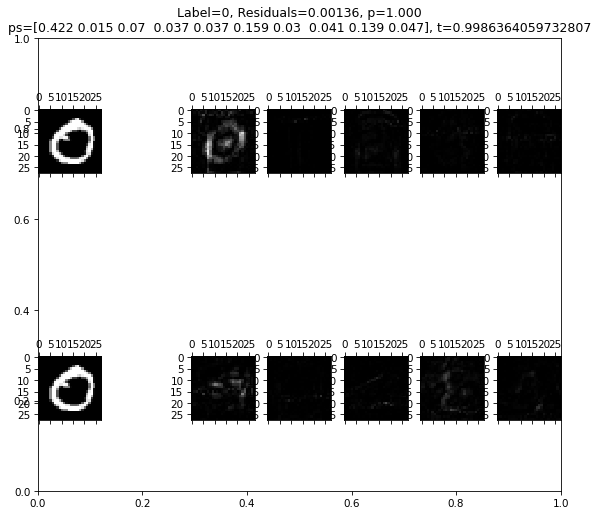

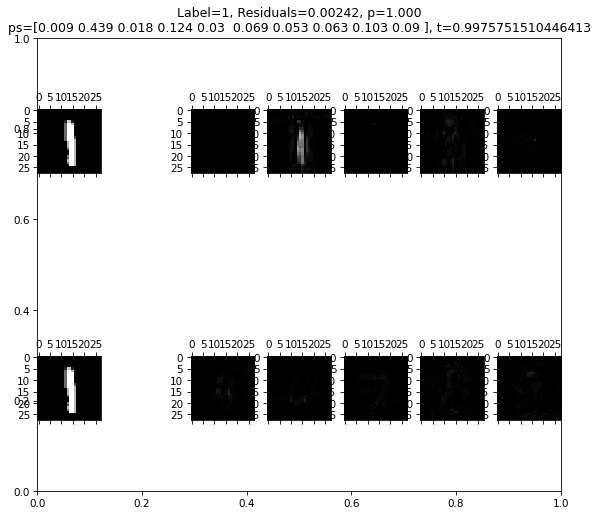

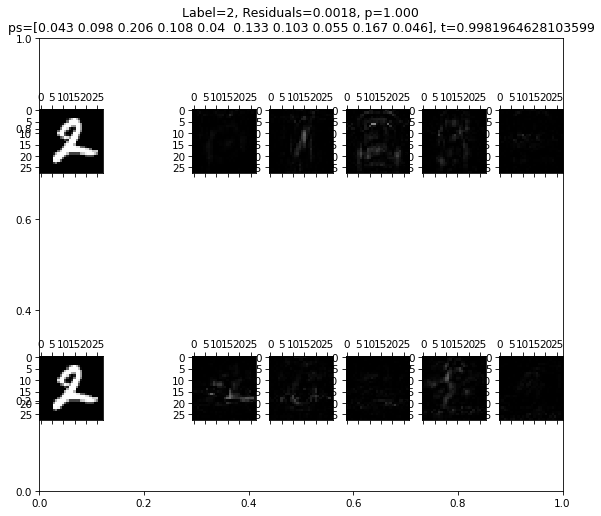

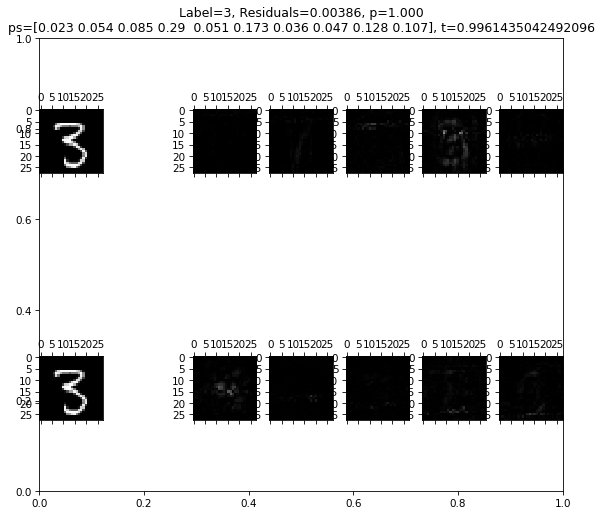

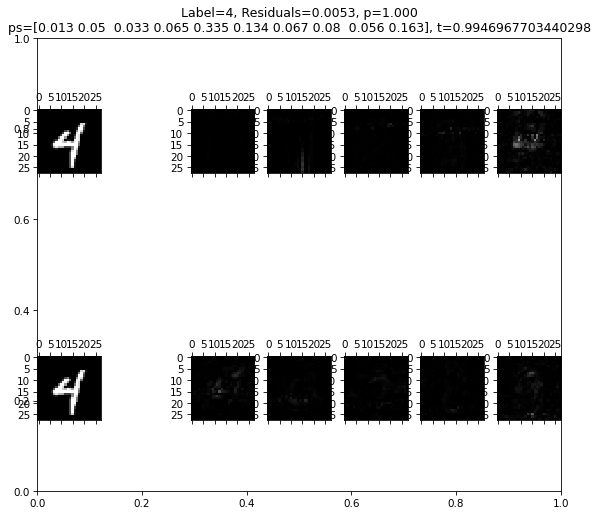

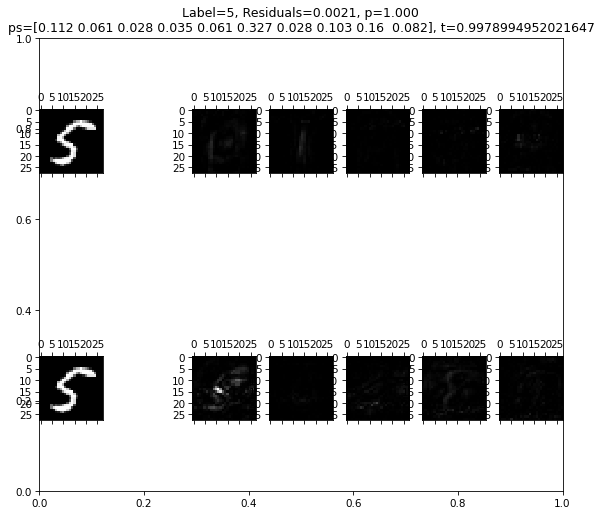

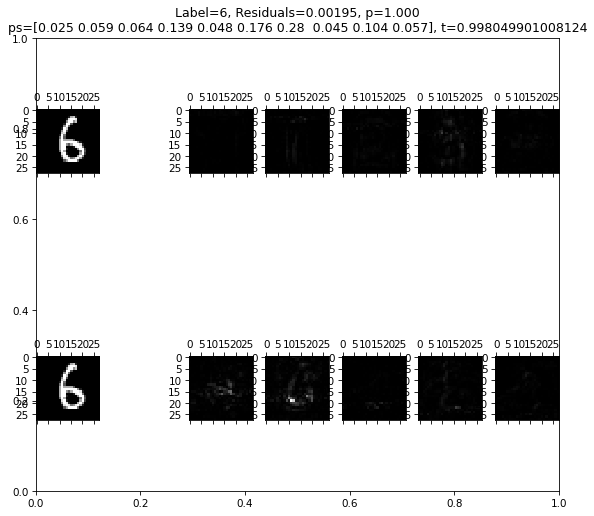

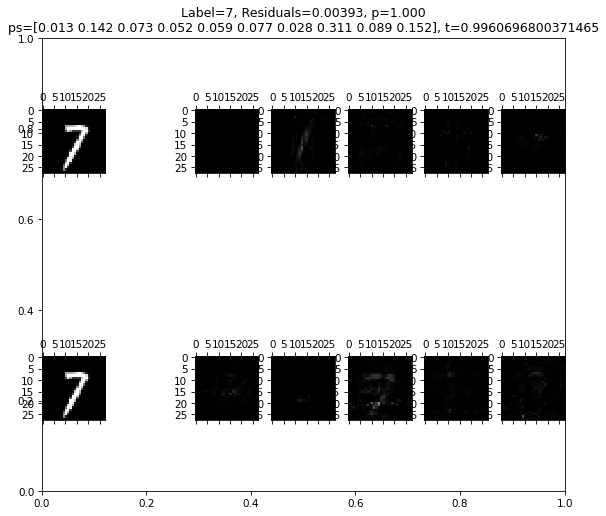

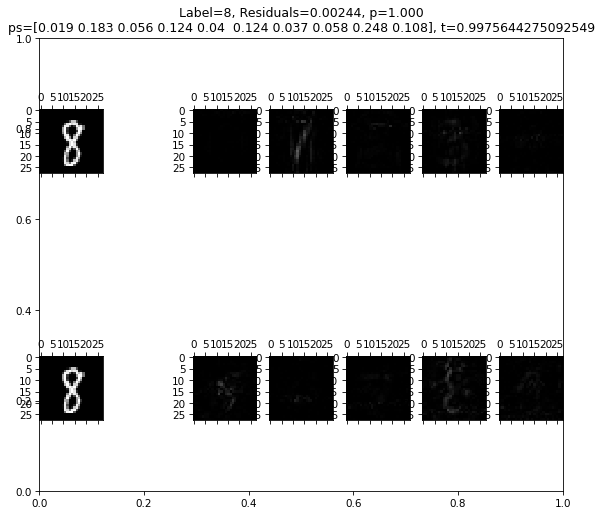

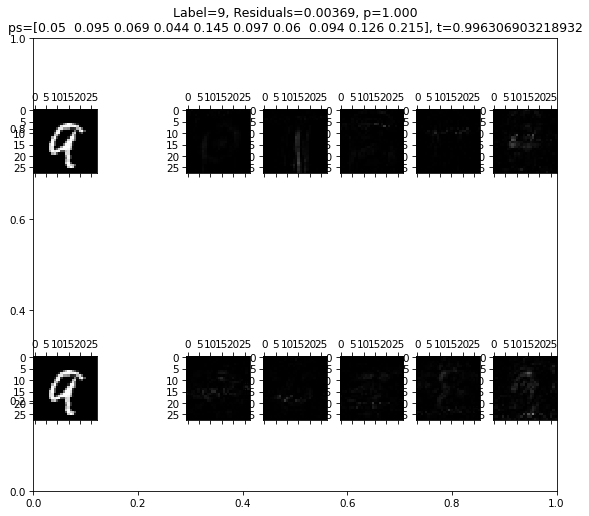

In [26]:
def decompose_img(xq_img):
  padding = XYDIM_EXT - xq_img.size
  psi = numpy.pad(xq_img.reshape(-1), (0, padding))
  proj_psi = numpy.einsum('cqp,p->cq', projectors, psi)
  proj_probs = (proj_psi * proj_psi.conj()).real
  proj_prob_residuals = proj_probs[:, XYDIM:].sum(axis=1)
  proj_pieces = proj_psi[:, :XYDIM].reshape((-1,) + xq_img.shape)
  return proj_prob_residuals, proj_pieces

def show_test_images(test_indices):
  for idx in test_indices:
    y = y_test[idx]
    xq = xq_test[idx][:XYDIM].reshape(x_test.shape[1:])
    x_probs = (xq * xq.conj()).real
    p_max = x_probs.max()
    residuals, q_pieces = decompose_img(xq)
    probs_pieces = (q_pieces * q_pieces.conj()).real
    tot_probs_pieces = probs_pieces.sum(axis=(1, 2)) # XXX
    fig = pyplot.figure(figsize=(9, 8), dpi=75, facecolor='w', edgecolor='k')
    ax = fig.gca()
    ax.set_title('Label=%s, Residuals=%5.3g, p=%.3f\nps=%s, t=%s' % 
                 (y, residuals.sum(), x_probs.sum(),
                  numpy.round(tot_probs_pieces, 3),
                  tot_probs_pieces.sum()))
    digit_locations = (3, 4, 5, 6, 7, 10, 11, 12, 13, 14)
    sp = fig.add_subplot(2, 7, 1)
    sp.matshow(x_probs, vmin=0, vmax=p_max, cmap='gray')
    # This does not work, due to missing destructive interference.
    # sp = fig.add_subplot(2, 7, 8)
    # sp.matshow(probs_pieces.sum(axis=0), vmin=0, vmax=p_max)
    sp = fig.add_subplot(2, 7, 8)
    sp.matshow(abs(q_pieces.sum(axis=0))**2, vmin=0, vmax=p_max, cmap='gray')
    for n in range(10):
      sp = fig.add_subplot(2, 7, digit_locations[n])
      sp.matshow(probs_pieces[n], vmin=0, vmax=p_max, cmap='gray')
    fig.show()

show_test_images([3000 + list(y_test[3000:]).index(k) for k in range(10)])